# Train and deploy a PyTorch NN model for movie rating on SageMaker

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
import boto3
from sklearn.utils import shuffle

### SageMaker configuration

In [2]:
# create boto session and sagemaker session
boto_session = boto3.Session(profile_name='ml_user_cli')
region = boto_session.region_name
sm_session = sagemaker.Session(boto_session=boto_session)

# get sagemaker execution role
try:
    role = get_execution_role(sm_session)
except ValueError:
    iam = boto_session.client('iam')
    role = iam.get_role(RoleName='AmazonSageMaker-ExecutionRole-20230328T205885')['Role']['Arn']
    print(role)

# set s3 bucket
bucket = sm_session.default_bucket()
print(bucket)

Couldn't call 'get_role' to get Role ARN from role name ml_user_cli to get Role path.


arn:aws:iam::335220673881:role/service-role/AmazonSageMaker-ExecutionRole-20230328T205885
sagemaker-us-east-1-335220673881


### Data preparation

In [3]:
df = pd.read_csv("rating.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
df = df.drop("timestamp", axis=1)

check how many users and movies in the dataset.

In [5]:
print("total number of users is {}".format(df['userId'].nunique()))
print("total number of movies is {}".format(df['movieId'].nunique()))
print("minimum user ID is {}, maximum user ID is {}".format(df['userId'].min(), df['userId'].max()))
print("minimum movie ID is {}, maximum movie ID is {}".format(df['movieId'].min(), df['movieId'].max()))

total number of users is 138493
total number of movies is 26744
minimum user ID is 1, maximum user ID is 138493
minimum movie ID is 1, maximum movie ID is 131262


Movie IDs are not continuous integers. We need to map them to new IDs.

In [6]:
user_ids = sorted(df['userId'].unique())
movie_ids = sorted(df['movieId'].unique())
map_userId = {v:i for i, v in enumerate(user_ids)}
map_movieId = {v:i for i, v in enumerate(movie_ids)}
df['new_user_id'] = df['userId'].map(map_userId)
df['new_movie_id'] = df['movieId'].map(map_movieId)

In [7]:
df.head()

,userId,movieId,rating,new_user_id,new_movie_id
0,1,2,3.5,0,1
1,1,29,3.5,0,28
2,1,32,3.5,0,31
3,1,47,3.5,0,46
4,1,50,3.5,0,49


Split data into train and test dataset. Save them in the format of numpy array.

In [8]:

data = df[['new_user_id', 'new_movie_id', 'rating']].to_numpy()
data = shuffle(data)
N = len(data)
idx_cut = int(N * 0.8)
train_data = data[:idx_cut]
test_data = data[idx_cut:]

np.save('train/train_data.npy', train_data)
np.save('test/test_data.npy', test_data)

# also save the number of users and movies in a file. They will be used to construct the neural network
N_users = df['new_user_id'].max() + 1
N_movies = df['new_movie_id'].max() + 1

with open('train/total_users_and_movies.txt', 'w') as f:
    f.write(f"{N_users},{N_movies}")


upload data into s3 for training

In [9]:
s3_client = boto_session.client('s3')
s3_prefix = "movieLens/"
train_file = "train/train_data.npy"
test_file = "test/test_data.npy"
param_file = "train/total_users_and_movies.txt"
s3_client.upload_file(train_file, bucket, s3_prefix + train_file)
s3_client.upload_file(test_file, bucket, s3_prefix + test_file)
s3_client.upload_file(param_file, bucket, s3_prefix + param_file)

### train model

In [10]:
hyperparameters = {
    "epochs": 50,
    "batch_size": 5120
}

In [11]:
from sagemaker.local import LocalSession

# set local_mode to true to train the model on local machine. It is for testing the algorithm
local_mode = False

if local_mode:
    sm_session = LocalSession(boto_session=boto3.Session(profile_name="ml_user_cli"))
    sm_session.config = {'local': {'local_code': True}}
    role = 'arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-20200101T000001'
    train_instance_type = "local"
    output_path = "file://model/"
    inputs = {
        "train": "file://train/",
        "test": "file://test/"
    }
else:
    train_instance_type = "ml.c5.4xlarge"
    output_path = "s3://{}/movieLens/model/".format(bucket)
    inputs = {
        "train": "s3://{}/movieLens/train/".format(bucket),
        "test": "s3://{}/movieLens/test/".format(bucket)
    }

In [12]:
inputs, output_path

({'train': 's3://sagemaker-us-east-1-335220673881/movieLens/train/',
  'test': 's3://sagemaker-us-east-1-335220673881/movieLens/test/'},
 's3://sagemaker-us-east-1-335220673881/movieLens/model/')

In [13]:
estimator = PyTorch(
    entry_point="train_and_inference.py",
    source_dir="code",
    instance_type=train_instance_type,
    instance_count = 1,
    hyperparameters = hyperparameters,
    sagemaker_session = sm_session,
    role = role,
    output_path=output_path,
    base_job_name = "pytorch-Model",
    framework_version="1.11",
    py_version="py38"
)

In [14]:
estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-Model-2023-06-26-02-00-33-158


Using provided s3_resource
2023-06-26 02:00:33 Starting - Starting the training job...
2023-06-26 02:00:53 Starting - Preparing the instances for training......
2023-06-26 02:01:55 Downloading - Downloading input data...
2023-06-26 02:02:20 Training - Downloading the training image...
2023-06-26 02:03:05 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-25 22:03:27,132 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-25 22:03:27,134 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-25 22:03:27,136 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-25 22:03:27,146 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-25 22:03:27,148 sagemaker_pytorch_container.training INF

Train and validation losses are stored in the output folder. Download the output data from s3 and visualize the results.

In [15]:
model_name = estimator._current_job_name
s3_client.download_file(bucket, "movieLens/model/" + model_name + "/output/output.tar.gz", "output/output.tar.gz")

In [16]:
!tar -xf output/output.tar.gz -C output/

In [17]:
loss_df = pd.read_csv("output/losses.csv", index_col=0)
loss_df.head()

,train_losses,test_losses
0,0.955161,0.822641
1,0.773900,0.754108
2,0.739502,0.745098
3,0.731376,0.738930
4,0.727777,0.740577


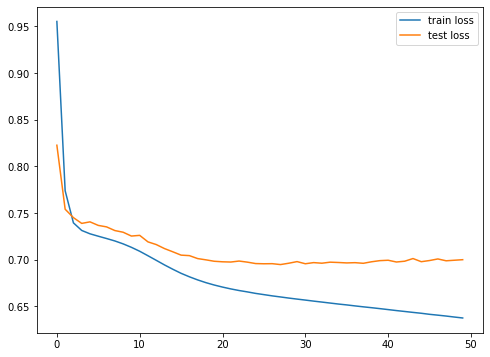

In [18]:
plt.figure(figsize=(8,6))
plt.plot(loss_df['train_losses'], label="train loss")
plt.plot(loss_df['test_losses'], label='test loss')
plt.legend()
plt.show()

### Deploy the trained model on sagemaker

In [19]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='pytorch-model'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-335220673881/movieLens/model/pytorch-Model-2023-06-26-02-00-33-158/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-335220673881/pytorch-Model-2023-06-26-02-00-33-158/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-335220673881/pytorch-Model-2023-06-26-02-36-32-314/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-Model-2023-06-26-02-36-32-314
INFO:sagemaker:Creating endpoint-config with name pytorch-model
INFO:sagemaker:Creating endpoint with name pytorch-model


-------!

In [20]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

In [21]:
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

### make inference using deployed endpoint

In [22]:
test_input = np.load("test/test_data.npy")

In [23]:
# two dimensional numpy array with three columns.
# the first column is user ID, second column is movie ID, and third column is rating. 
# we need the first two columns as input for the predictor
test_input[:5]

array([[8.5243e+04, 9.5640e+03, 4.0000e+00],
       [5.3163e+04, 4.4000e+01, 3.0000e+00],
       [3.8361e+04, 1.1130e+03, 5.0000e+00],
       [4.5470e+04, 2.2490e+03, 1.0000e+00],
       [9.6352e+04, 1.3280e+03, 5.0000e+00]])

In [24]:
sample = test_input[:20,:2]
sample

array([[8.52430e+04, 9.56400e+03],
       [5.31630e+04, 4.40000e+01],
       [3.83610e+04, 1.11300e+03],
       [4.54700e+04, 2.24900e+03],
       [9.63520e+04, 1.32800e+03],
       [9.84950e+04, 7.04100e+03],
       [7.54770e+04, 8.91000e+02],
       [1.28035e+05, 1.27500e+03],
       [7.14690e+04, 5.89000e+03],
       [7.15900e+04, 3.81700e+03],
       [1.14800e+05, 5.31000e+02],
       [2.89050e+04, 1.83900e+03],
       [1.30476e+05, 4.79100e+03],
       [1.76010e+04, 1.25700e+04],
       [1.10617e+05, 2.34800e+03],
       [3.78240e+04, 1.91600e+03],
       [8.02000e+03, 1.22400e+03],
       [9.43450e+04, 2.30200e+03],
       [1.66130e+04, 1.19900e+03],
       [5.02520e+04, 1.26580e+04]])

Predict the ratings for a sample input data

In [25]:
predictor.predict(sample)

[3.6819026470184326,
 3.6196787357330322,
 4.460675239562988,
 3.6950528621673584,
 3.15885591506958,
 3.0009536743164062,
 4.534146308898926,
 4.044096946716309,
 3.6700918674468994,
 3.396740674972534,
 3.934185743331909,
 3.758690595626831,
 2.765838861465454,
 0.6914318203926086,
 3.6143033504486084,
 4.176187992095947,
 4.7065348625183105,
 2.964540481567383,
 2.644045114517212,
 3.296950578689575]

In [26]:
def batch_prediction(inputs, predictor):
    batches = int(np.ceil(len(inputs)/5000))
    results = []
    for i in range(batches):
        x_batch = inputs[i*5000:(i+1)*5000, :2]
        results += predictor.predict(x_batch)

    return results

make prediction for all the test dataset

In [27]:
rating_pred = batch_prediction(test_input, predictor)

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
rating_actual = test_input[:,2]
print("the mean squared error for test dataset is {}".format(mean_squared_error(rating_pred, rating_actual)))

the mean squared error for test dataset is 0.7000429989639377


check the prediction residuals

In [30]:
residual = np.array(rating_pred) - np.array(rating_actual)

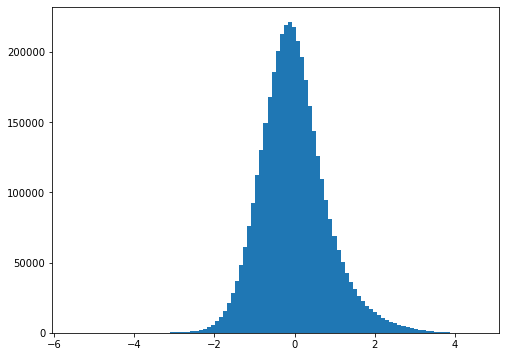

In [31]:
plt.figure(figsize=(8,6))
plt.hist(residual, bins=100)
plt.show()

### Recommend movies to users

In [32]:
movie_df = pd.read_csv("movie.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Count movie genres

In [33]:
genres_set = set()
for genres in movie_df['genres']:
    for g in genres.split("|"):
        genres_set.add(g.strip())

genres_list = sorted(list(genres_set))
n_genre = len(genres_list)
genres_list

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

one-hot encode the movie genres to make it easier for filtering movies by categories

In [34]:
n_movie = movie_df.shape[0]
genre_df = pd.DataFrame(np.zeros((n_movie, n_genre), dtype=int), columns=genres_list)
for i, genre in enumerate(movie_df['genres']):
    for g in genre.split("|"):
        genre_df.loc[i, g.strip()] = 1

genre_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
movie_df2 = pd.concat([movie_df, genre_df], axis=1)
movie_df2.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


create function to generate the numpy array input for predicting ratings of all movies for a specific user ID.  
**Note the IDs are new user ID and new movie ID**

In [36]:
def one_user_input(userId):
    input_arr = np.zeros((N_movies, 2), dtype=int)
    input_arr[:,0] = userId
    input_arr[:,1] = np.arange(N_movies)
    return input_arr

In [37]:
one_user_input(3)

array([[    3,     0],
       [    3,     1],
       [    3,     2],
       ...,
       [    3, 26741],
       [    3, 26742],
       [    3, 26743]])

Now, predict the ratings of all movies for user ID.

In [38]:
def predict_for_user(userId):
    input_arr = one_user_input(userId)
    one_user_rating_df = pd.DataFrame(input_arr, columns=['new_user_id', 'new_movie_id'])
    one_user_rating_df['rating_pred'] = predictor.predict(input_arr)
    return one_user_rating_df

In [39]:
predict_for_user(1)

,new_user_id,new_movie_id,rating_pred
0,1,0,4.409844
1,1,1,3.776822
2,1,2,3.740627
3,1,3,3.217554
4,1,4,3.524639
...,...,...,...
26739,1,26739,3.452080
26740,1,26740,4.509295
26741,1,26741,2.880450
26742,1,26742,3.910204


Make recommendation for a specific user. The following function returns the recommended movies and movies that have already been watched by the user.

In [40]:
def recommend_for_user(userId, genre = None):
    """
    return two pandas DataFrame: recommended movies and watched movies
    """
    all_rating = predict_for_user(userId)
    # map the new IDs back to original IDs
    all_rating['userId'] = all_rating['new_user_id'].map(lambda x : user_ids[x]) #user_ids is a list of old ids
    all_rating['movieId'] = all_rating['new_movie_id'].map(lambda x: movie_ids[x]) #movie_ids is a list of old ids
    all_rating = all_rating.merge(movie_df2, how='left', on='movieId')

    #check the movies that have already been watched by users
    watched_df = df[df['new_user_id'] == userId]
    watched_df = watched_df.merge(movie_df2, how='left', on='movieId')
    watched_list = watched_df['movieId'].tolist()

    if genre:
        #select the movies that are not in the watched list and has the specified genre
        selecting = (~all_rating['movieId'].isin(watched_list)) & (all_rating[genre]==1)
        recommended_movies = all_rating[selecting]
    else:
        recommended_movies = all_rating[~all_rating['movieId'].isin(watched_list)]

    return recommended_movies.sort_values(by='rating_pred', ascending=False).reset_index(drop=True),\
          watched_df.sort_values(by='rating', ascending=False).reset_index(drop=True)


In [41]:
recommend, watched = recommend_for_user(12345)

Show the top 10 movies watched by the user

In [42]:
watched.iloc[:,:7].head(10)

,userId,movieId,rating,new_user_id,new_movie_id,title,genres
0,12346,357,5.0,12345,353,Four Weddings and a Funeral (1994),Comedy|Romance
1,12346,539,5.0,12345,535,Sleepless in Seattle (1993),Comedy|Drama|Romance
2,12346,508,5.0,12345,504,Philadelphia (1993),Drama
3,12346,318,5.0,12345,315,"Shawshank Redemption, The (1994)",Crime|Drama
4,12346,300,4.0,12345,297,Quiz Show (1994),Drama
5,12346,590,4.0,12345,584,Dances with Wolves (1990),Adventure|Drama|Western
6,12346,553,4.0,12345,549,Tombstone (1993),Action|Drama|Western
7,12346,527,4.0,12345,523,Schindler's List (1993),Drama|War
8,12346,480,4.0,12345,476,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
9,12346,457,4.0,12345,453,"Fugitive, The (1993)",Thriller


Show the top 10 movies recommended for the user

In [43]:
recommend.iloc[:,:7].head(10)

,new_user_id,new_movie_id,rating_pred,userId,movieId,title,genres
0,12345,22215,5.849219,12346,107252,Island at War (2004),Drama|War
1,12345,20210,5.758446,12346,99724,K-11 (2012),Crime|Drama
2,12345,26138,5.696417,12346,128187,Freedom Song (2000),Drama
3,12345,26557,5.695791,12346,130347,Bill Hicks: Sane Man (1989),Comedy
4,12345,20140,5.632021,12346,99450,Sun Kissed (2012),Documentary
5,12345,25305,5.564713,12346,121374,Bill Burr: Why Do I Do This? (2008),Comedy
6,12345,21657,5.554166,12346,105189,Emo Philips Live (1987),Comedy
7,12345,12281,5.551993,12346,56548,All Passion Spent (1986),Drama
8,12345,15150,5.490038,12346,77344,Chizuko's Younger Sister (Futari) (1991),Drama
9,12345,22351,5.487239,12346,107730,By the People: The Election of Barack Obama (2...,Documentary


### Cleanup

In [44]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-model
INFO:sagemaker:Deleting endpoint with name: pytorch-model
